In [ ]:
import uproot
import awkward as ak
import dask_awkward as dak
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from distributed import LocalCluster, Client, progress

client =  Client(n_workers=31,  threads_per_worker=1, processes=True, memory_limit='4 GiB') 


import json
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.CMS)
import numpy as np


/depot/cms/users/yun79/conda_envs/coffea_prototype/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38139 instead
  warnings.warn(


In [ ]:
def applyVbfCatCut(events, apply_filter=False, is_within_filter_phase=False):
    # apply signal region cut
    region = events.h_sidebands | events.h_peak
    # do category cut
    btag_cut =ak.fill_none((events.nBtagLoose >= 2), value=False) | ak.fill_none((events.nBtagMedium >= 1), value=False)
    prod_cat_cut = ak.fill_none(events.vbf_cut, value=False) # in the future none values will be replaced with False
    if apply_filter: # apply the filter cut
        if is_within_filter_phase:
            vbf_filter = ak.fill_none((events.gjj_mass > 350), value=False)
            prod_cat_cut =  (prod_cat_cut  & vbf_filter)
        else:
            vbf_filter = ak.fill_none((events.gjj_mass > 350), value=False)
            prod_cat_cut =  (prod_cat_cut  & ~vbf_filter)
    category_selection = (
        prod_cat_cut & 
        region &
        ~btag_cut # btag cut is for VH and ttH categories
    )
    return events[category_selection]

def getHist(zip_l, field2plot:str, binning):
    """
    zip_l is list of zip of already computed stuff
    """
    weights_l = []
    values_l = []
    for zip in zip_l:
        weights = ak.to_numpy(zip.wgt_nominal_total)
        values = ak.to_numpy(zip[field2plot])
        weights_l.append(weights)
        values_l.append(values)
    
    values_total = np.concatenate(values_l, axis=0)
    weights_total = np.concatenate(weights_l, axis=0)
    hist, edges = np.histogram(values_total, bins=binning, weights=weights_total)
    hist_w2, edges = np.histogram(values_total, bins=binning, weights=weights_total*weights_total)
    total_yield = len(weights_total)
    return hist, hist_w2, total_yield

def toZipAndCompute(events, fields2plot):
    zip = ak.zip({
        field : events[field] for field in fields2plot
    }).compute()
    return zip

In [ ]:
load_path = "/depot/cms/users/yun79/results/stage1/DNN_test2/2018/f1_0/"
GoodUL_events = dak.from_parquet(load_path + "dy_VBF_filter_fromGridpack/*/*.parquet")
DyIncl_events = dak.from_parquet(load_path + "dy_M-100To200/*/*.parquet")
GoodRERECO_events = dak.from_parquet(load_path + "dy_m105_160_vbf_amc/*/*.parquet")

In [ ]:
DyIncl_events_full = applyVbfCatCut(DyIncl_events)
DyIncl_events_outside_phase = applyVbfCatCut(DyIncl_events, apply_filter=True, is_within_filter_phase=False)
GoodUL_events = applyVbfCatCut(GoodUL_events, apply_filter=True, is_within_filter_phase=True)
GoodRERECO_events = applyVbfCatCut(GoodRERECO_events, apply_filter=True, is_within_filter_phase=True)
DyIncl_events_inside_phase = applyVbfCatCut(DyIncl_events, apply_filter=True, is_within_filter_phase=True)


In [ ]:
with open("plot_settings.json", "r") as file:
    plot_bins = json.load(file)
# fields2plot = ["dimuon_pt", "wgt_nominal_total"]
fields2plot = DyIncl_events.fields



DyIncl_events_full = toZipAndCompute(DyIncl_events_full,fields2plot)
DyIncl_events_outside_phase = toZipAndCompute(DyIncl_events_outside_phase, fields2plot)
GoodUL_events = toZipAndCompute(GoodUL_events,fields2plot)
GoodRERECO_events = toZipAndCompute(GoodRERECO_events,fields2plot)
DyIncl_events_inside_phase = toZipAndCompute(DyIncl_events_inside_phase, fields2plot)

# we don't plot weights so remove them
for field in fields2plot:
    if ("wgt_nominal" in field):
        fields2plot.remove(field)
print(fields2plot)


In [ ]:
for field in fields2plot:
    if field not in plot_bins.keys():
        continue
    binning = np.linspace(*plot_bins[field]["binning_linspace"])
    fig, ax_main = plt.subplots()
    
    hist_GoodUL, hist_GoodUL_w2, total_yield_GoodUL = getHist([DyIncl_events_outside_phase, GoodUL_events], field, binning)
    hist_GoodRERECO, hist_GoodRERECO_w2, total_yield_GoodRERECO = getHist([DyIncl_events_outside_phase, GoodRERECO_events], field, binning)
    hist_Incl, hist_Incl_w2, total_yield_GoodIncl = getHist([DyIncl_events_full], field, binning)
    
    
        
    hep.histplot(hist_GoodUL, bins=binning, 
             histtype='errorbar', 
            label=f"UL + Incl, nevents: {format(int(total_yield_GoodUL), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_GoodUL_w2),
            color = "blue",
            ax=ax_main
    )
    hep.histplot(hist_GoodRERECO, bins=binning, 
             histtype='errorbar', 
            label=f"RERECO + Incl, nevents: {format(int(total_yield_GoodRERECO), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_GoodRERECO_w2),
            color = "red",
            ax=ax_main
    )
    hep.histplot(hist_Incl, bins=binning, 
             histtype='errorbar', 
            label=f"Incl Only, nevents: {format(int(total_yield_GoodIncl), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_Incl_w2),
            color = "green",
            ax=ax_main
    )
    # ax_main.set_ylim([0,650])
    
    ax_main.set_xlabel( plot_bins[field].get("xlabel"))
    plt.title(f"{field} dist for normal phase space")
    # plt.legend(loc="upper right")
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    # plt.show()
    save_path = "./quick_plots/VBF_filterDYComparision_Sept12_2024"
    save_full_path = save_path + f"/pdf/{field}.pdf"
    plt.savefig(save_full_path,bbox_inches='tight')
    save_full_path = save_path + f"/png/{field}.png"
    plt.savefig(save_full_path,bbox_inches='tight')

    # plot statistical errors:
    fig, ax_main = plt.subplots()
    hep.histplot(np.sqrt(hist_GoodUL_w2)/hist_GoodUL, bins=binning, 
             histtype='step', 
            label=f"UL + Incl", 
            color = "blue",
            ax=ax_main
    )
    hep.histplot(np.sqrt(hist_GoodRERECO_w2)/hist_GoodRERECO, bins=binning, 
             histtype='step', 
            label=f"RERECO + Incl", 
            color = "red",
            ax=ax_main
    )
    hep.histplot(np.sqrt(hist_Incl_w2)/hist_Incl, bins=binning, 
             histtype='step', 
            label=f"Incl only", 
            color = "green",
            ax=ax_main
    )
    plt.title(f"Rel. Stat. Err of {field} in VBF-filter phase space")
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    # plt.show()
    save_full_path = save_path + f"/pdf/{field}_relErr.pdf"
    plt.savefig(save_full_path ,bbox_inches='tight')
    save_full_path = save_path + f"/png/{field}_relErr.png"
    plt.savefig(save_full_path ,bbox_inches='tight')

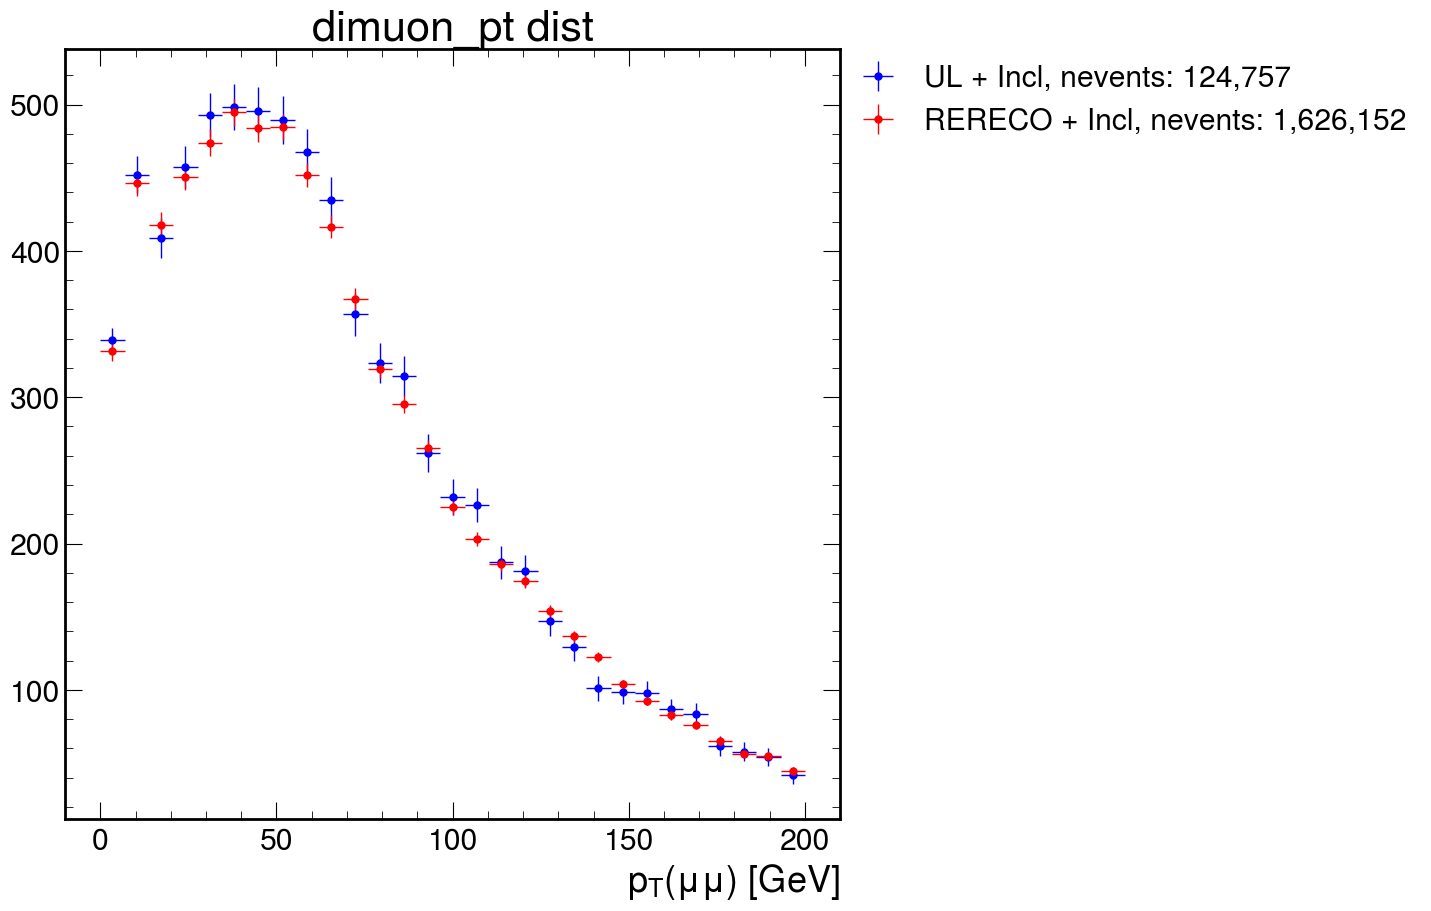

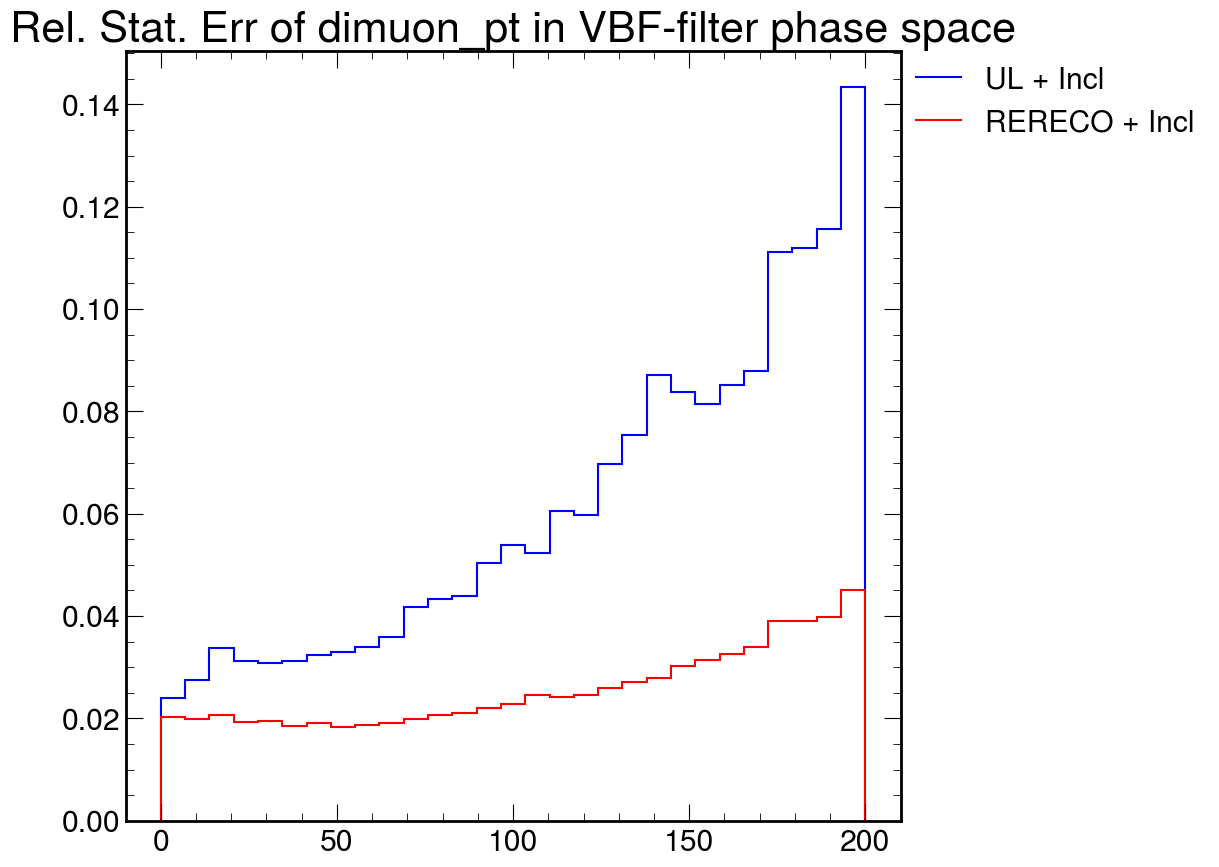

In [7]:
for field in fields2plot:
    if field not in plot_bins.keys():
        continue
    binning = np.linspace(*plot_bins[field]["binning_linspace"])
    fig, ax_main = plt.subplots()
    
    hist_GoodUL, hist_GoodUL_w2, total_yield_GoodUL = getHist([DyIncl_events_outside_phase, GoodUL_events], field, binning)
    hist_GoodRERECO, hist_GoodRERECO_w2, total_yield_GoodRERECO = getHist([DyIncl_events_outside_phase, GoodRERECO_events], field, binning)
    hist_Incl, hist_Incl_w2, total_yield_GoodIncl = getHist([DyIncl_events_full], field, binning)

    
    
        
    hep.histplot(hist_GoodUL, bins=binning, 
             histtype='errorbar', 
            label=f"UL + Incl, nevents: {format(int(total_yield_GoodUL), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_GoodUL_w2),
            color = "blue",
            ax=ax_main
    )
    hep.histplot(hist_GoodRERECO, bins=binning, 
             histtype='errorbar', 
            label=f"RERECO + Incl, nevents: {format(int(total_yield_GoodRERECO), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_GoodRERECO_w2),
            color = "red",
            ax=ax_main
    )
    # ax_main.set_ylim([0,650])
    
    ax_main.set_xlabel( plot_bins[field].get("xlabel"))
    plt.title(f"{field} dist")
    # plt.legend(loc="upper right")
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.show()
    # save_full_path = f"./quick_plots/PrivateProd_{field}.pdf"
    # save_full_path = f"./quick_plots/PrivateProd_{field}.png"
    # plt.savefig
    
    # plot statistical errors:
    fig, ax_main = plt.subplots()
    hep.histplot(np.sqrt(hist_GoodUL_w2)/hist_GoodUL, bins=binning, 
             histtype='step', 
            label=f"UL + Incl", 
            color = "blue",
            ax=ax_main
    )
    hep.histplot(np.sqrt(hist_GoodRERECO_w2)/hist_GoodRERECO, bins=binning, 
             histtype='step', 
            label=f"RERECO + Incl", 
            color = "red",
            ax=ax_main
    )
    plt.title(f"Rel. Stat. Err of {field} in VBF-filter phase space")
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.show()

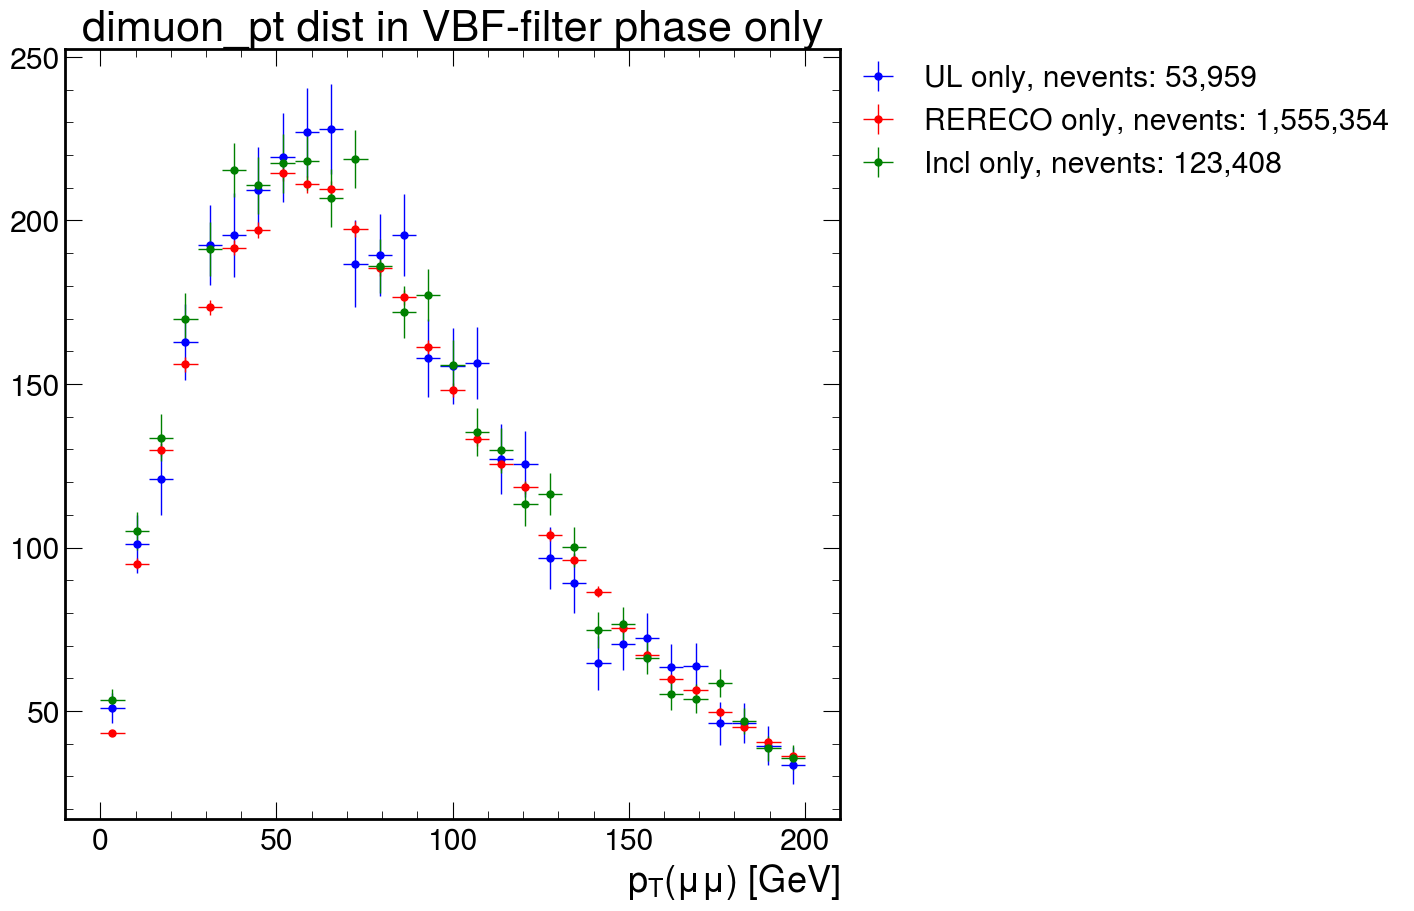

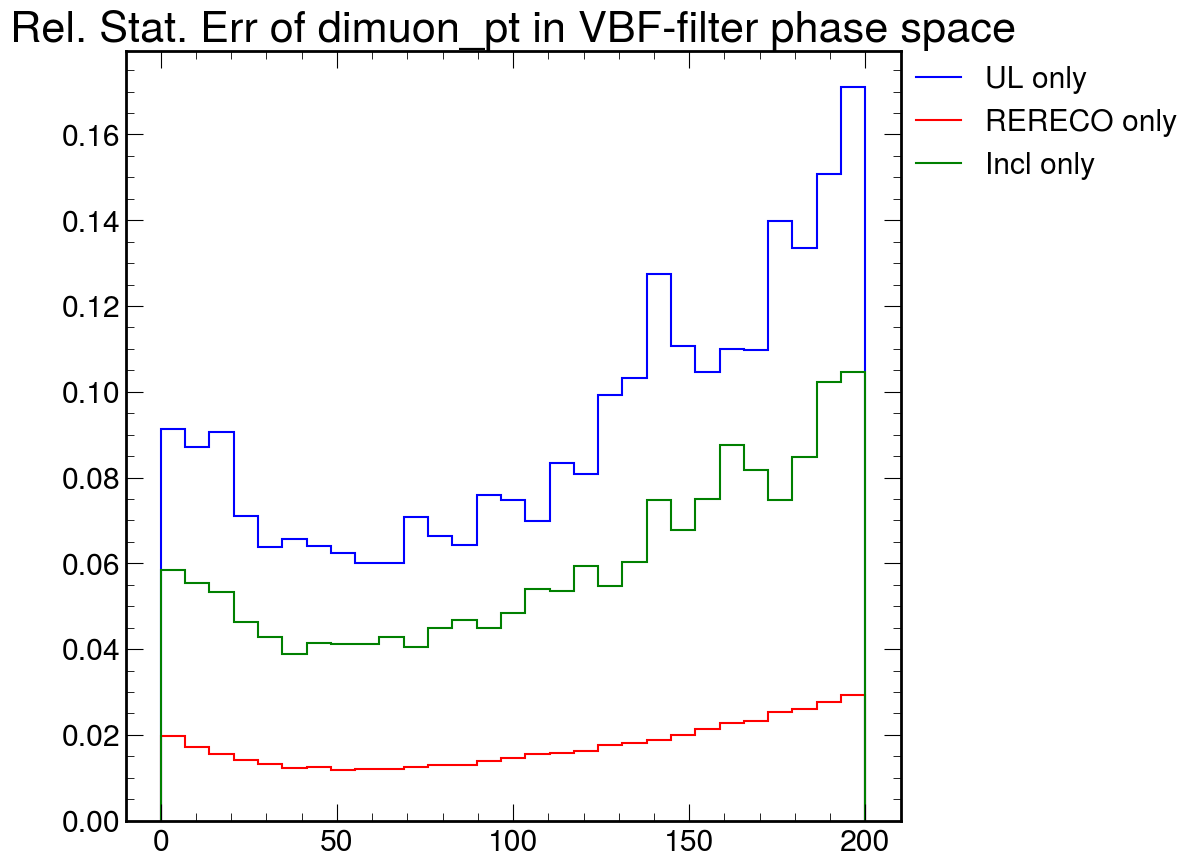

In [9]:
for field in fields2plot:
    if field not in plot_bins.keys():
        continue
    binning = np.linspace(*plot_bins[field]["binning_linspace"])
    fig, ax_main = plt.subplots()
    
    hist_GoodUL, hist_GoodUL_w2, total_yield_GoodUL = getHist([GoodUL_events], field, binning)
    hist_GoodRERECO, hist_GoodRERECO_w2, total_yield_GoodRERECO = getHist([GoodRERECO_events], field, binning)
    hist_Incl, hist_Incl_w2, total_yield_GoodIncl = getHist([DyIncl_events_inside_phase], field, binning)
    
    
        
    hep.histplot(hist_GoodUL, bins=binning, 
             histtype='errorbar', 
            label=f"UL only, nevents: {format(int(total_yield_GoodUL), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_GoodUL_w2),
            color = "blue",
            ax=ax_main
    )
    hep.histplot(hist_GoodRERECO, bins=binning, 
             histtype='errorbar', 
            label=f"RERECO only, nevents: {format(int(total_yield_GoodRERECO), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_GoodRERECO_w2),
            color = "red",
            ax=ax_main
    )
    hep.histplot(hist_Incl, bins=binning, 
             histtype='errorbar', 
            label=f"Incl only, nevents: {format(int(total_yield_GoodIncl), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_Incl_w2),
            color = "green",
            ax=ax_main
    )
    
    ax_main.set_xlabel( plot_bins[field].get("xlabel"))
    plt.title(f"{field} dist in VBF-filter phase only")
    # plt.legend(loc="upper right")
    # plt.legend(frameon=True)
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.show()
    # save_full_path = f"./quick_plots/PrivateProd_{field}.pdf"
    # save_full_path = f"./quick_plots/PrivateProd_{field}.png"
    # plt.savefig

    # plot statistical errors:
    fig, ax_main = plt.subplots()
    hep.histplot(np.sqrt(hist_GoodUL_w2)/hist_GoodUL, bins=binning, 
             histtype='step', 
            label=f"UL only", 
            color = "blue",
            ax=ax_main
    )
    hep.histplot(np.sqrt(hist_GoodRERECO_w2)/hist_GoodRERECO, bins=binning, 
             histtype='step', 
            label=f"RERECO only", 
            color = "red",
            ax=ax_main
    )
    hep.histplot(np.sqrt(hist_Incl_w2)/hist_Incl, bins=binning, 
             histtype='step', 
            label=f"Incl only", 
            color = "green",
            ax=ax_main
    )
    plt.title(f"Rel. Stat. Err of {field} in VBF-filter phase space")
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.show()

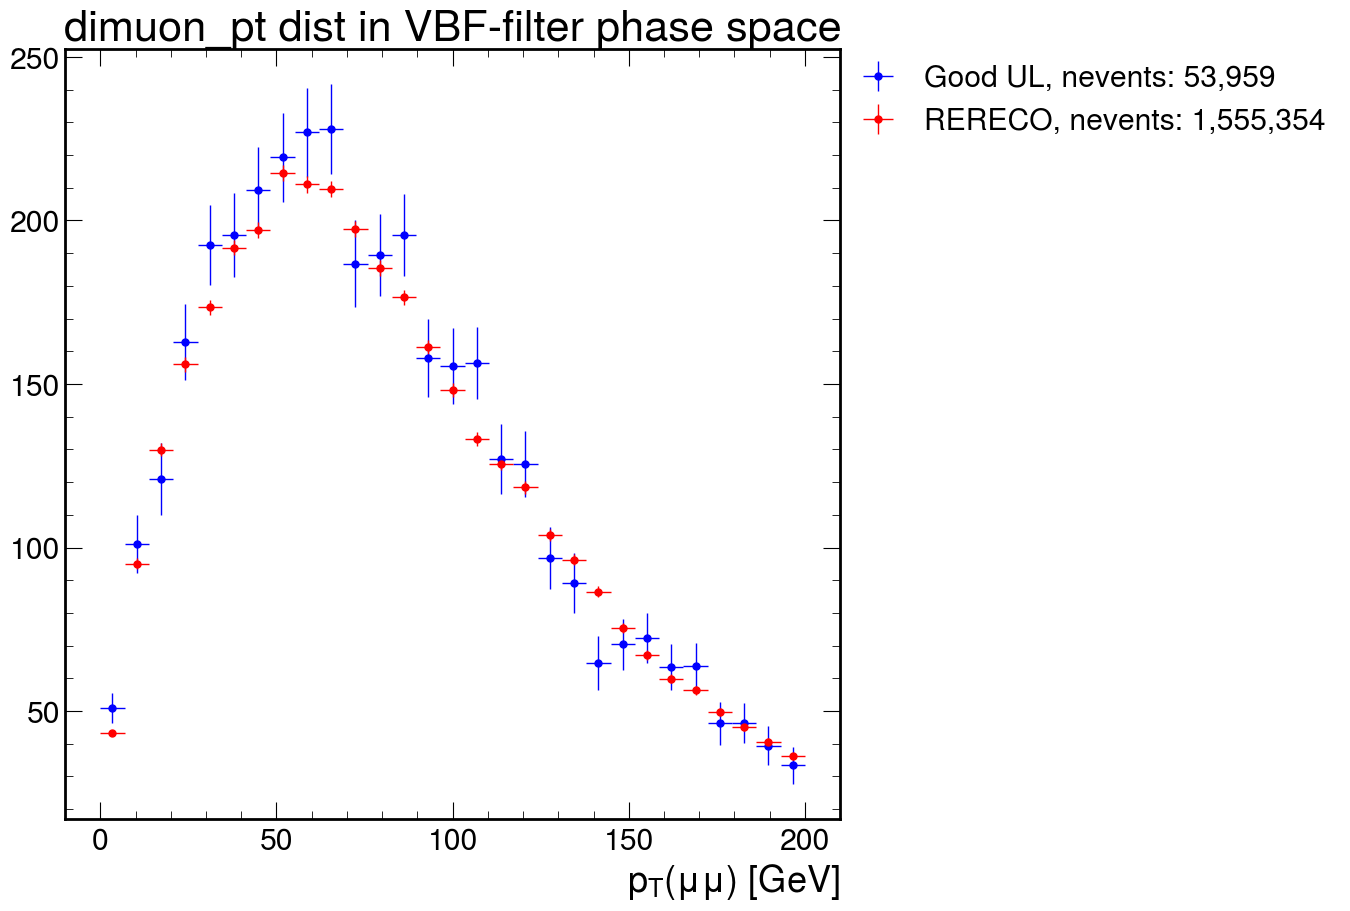

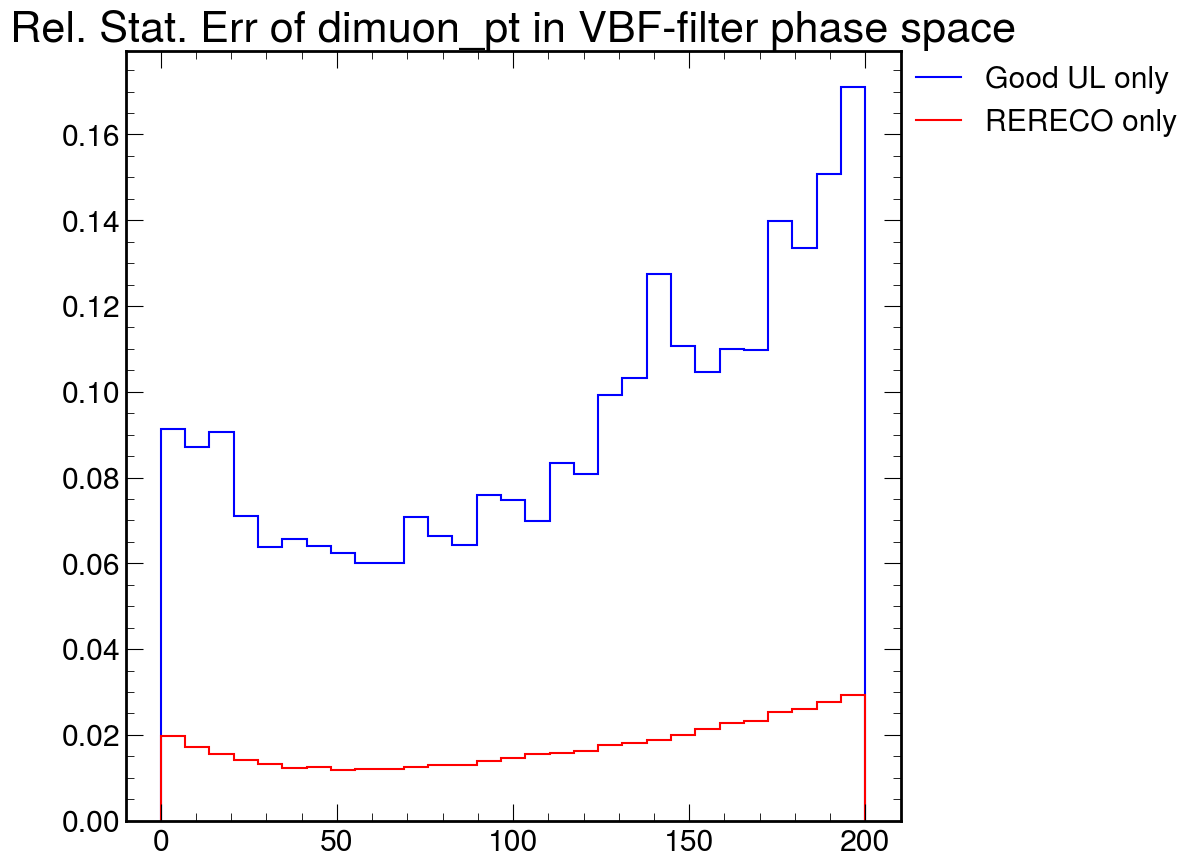

In [10]:
for field in fields2plot:
    if field not in plot_bins.keys():
        continue
    binning = np.linspace(*plot_bins[field]["binning_linspace"])
    fig, ax_main = plt.subplots()
    
    hist_GoodUL, hist_GoodUL_w2, total_yield_GoodUL = getHist([GoodUL_events], field, binning)
    hist_GoodRERECO, hist_GoodRERECO_w2, total_yield_GoodRERECO = getHist([GoodRERECO_events], field, binning)   
    
        
    hep.histplot(hist_GoodUL, bins=binning, 
             histtype='errorbar', 
            label=f"Good UL, nevents: {format(int(total_yield_GoodUL), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_GoodUL_w2),
            color = "blue",
            ax=ax_main
    )
    hep.histplot(hist_GoodRERECO, bins=binning, 
             histtype='errorbar', 
            label=f"RERECO, nevents: {format(int(total_yield_GoodRERECO), ",")}", 
             xerr=True, 
             yerr=np.sqrt(hist_GoodRERECO_w2),
            color = "red",
            ax=ax_main
    )
    
    ax_main.set_xlabel( plot_bins[field].get("xlabel"))
    plt.title(f"{field} dist in VBF-filter phase space")
    # plt.legend(loc="upper right")
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.show()
    # save_full_path = f"./quick_plots/PrivateProd_{field}.pdf"
    # save_full_path = f"./quick_plots/PrivateProd_{field}.png"
    # plt.savefig


    # plot statistical errors:
    fig, ax_main = plt.subplots()
    hep.histplot(np.sqrt(hist_GoodUL_w2)/hist_GoodUL, bins=binning, 
             histtype='step', 
            label=f"Good UL only", 
            color = "blue",
            ax=ax_main
    )
    hep.histplot(np.sqrt(hist_GoodRERECO_w2)/hist_GoodRERECO, bins=binning, 
             histtype='step', 
            label=f"RERECO only", 
            color = "red",
            ax=ax_main
    )
    plt.title(f"Rel. Stat. Err of {field} in VBF-filter phase space")
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
    plt.show()

In [11]:
binning

array([  0.        ,   6.89655172,  13.79310345,  20.68965517,
        27.5862069 ,  34.48275862,  41.37931034,  48.27586207,
        55.17241379,  62.06896552,  68.96551724,  75.86206897,
        82.75862069,  89.65517241,  96.55172414, 103.44827586,
       110.34482759, 117.24137931, 124.13793103, 131.03448276,
       137.93103448, 144.82758621, 151.72413793, 158.62068966,
       165.51724138, 172.4137931 , 179.31034483, 186.20689655,
       193.10344828, 200.        ])

In [12]:
len(hist_GoodRERECO_w2)


29

In [13]:
len(hist_GoodRERECO)

29